<a href="https://colab.research.google.com/github/DenisPotekhin2002/Generative-Models-2025/blob/main/Assignment%203/3_tricks_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Models
***

**Autumn 2025, MSc course**


## Assignment 3

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Rostislav Korst*

***


### Метрики качества генерации:

IS

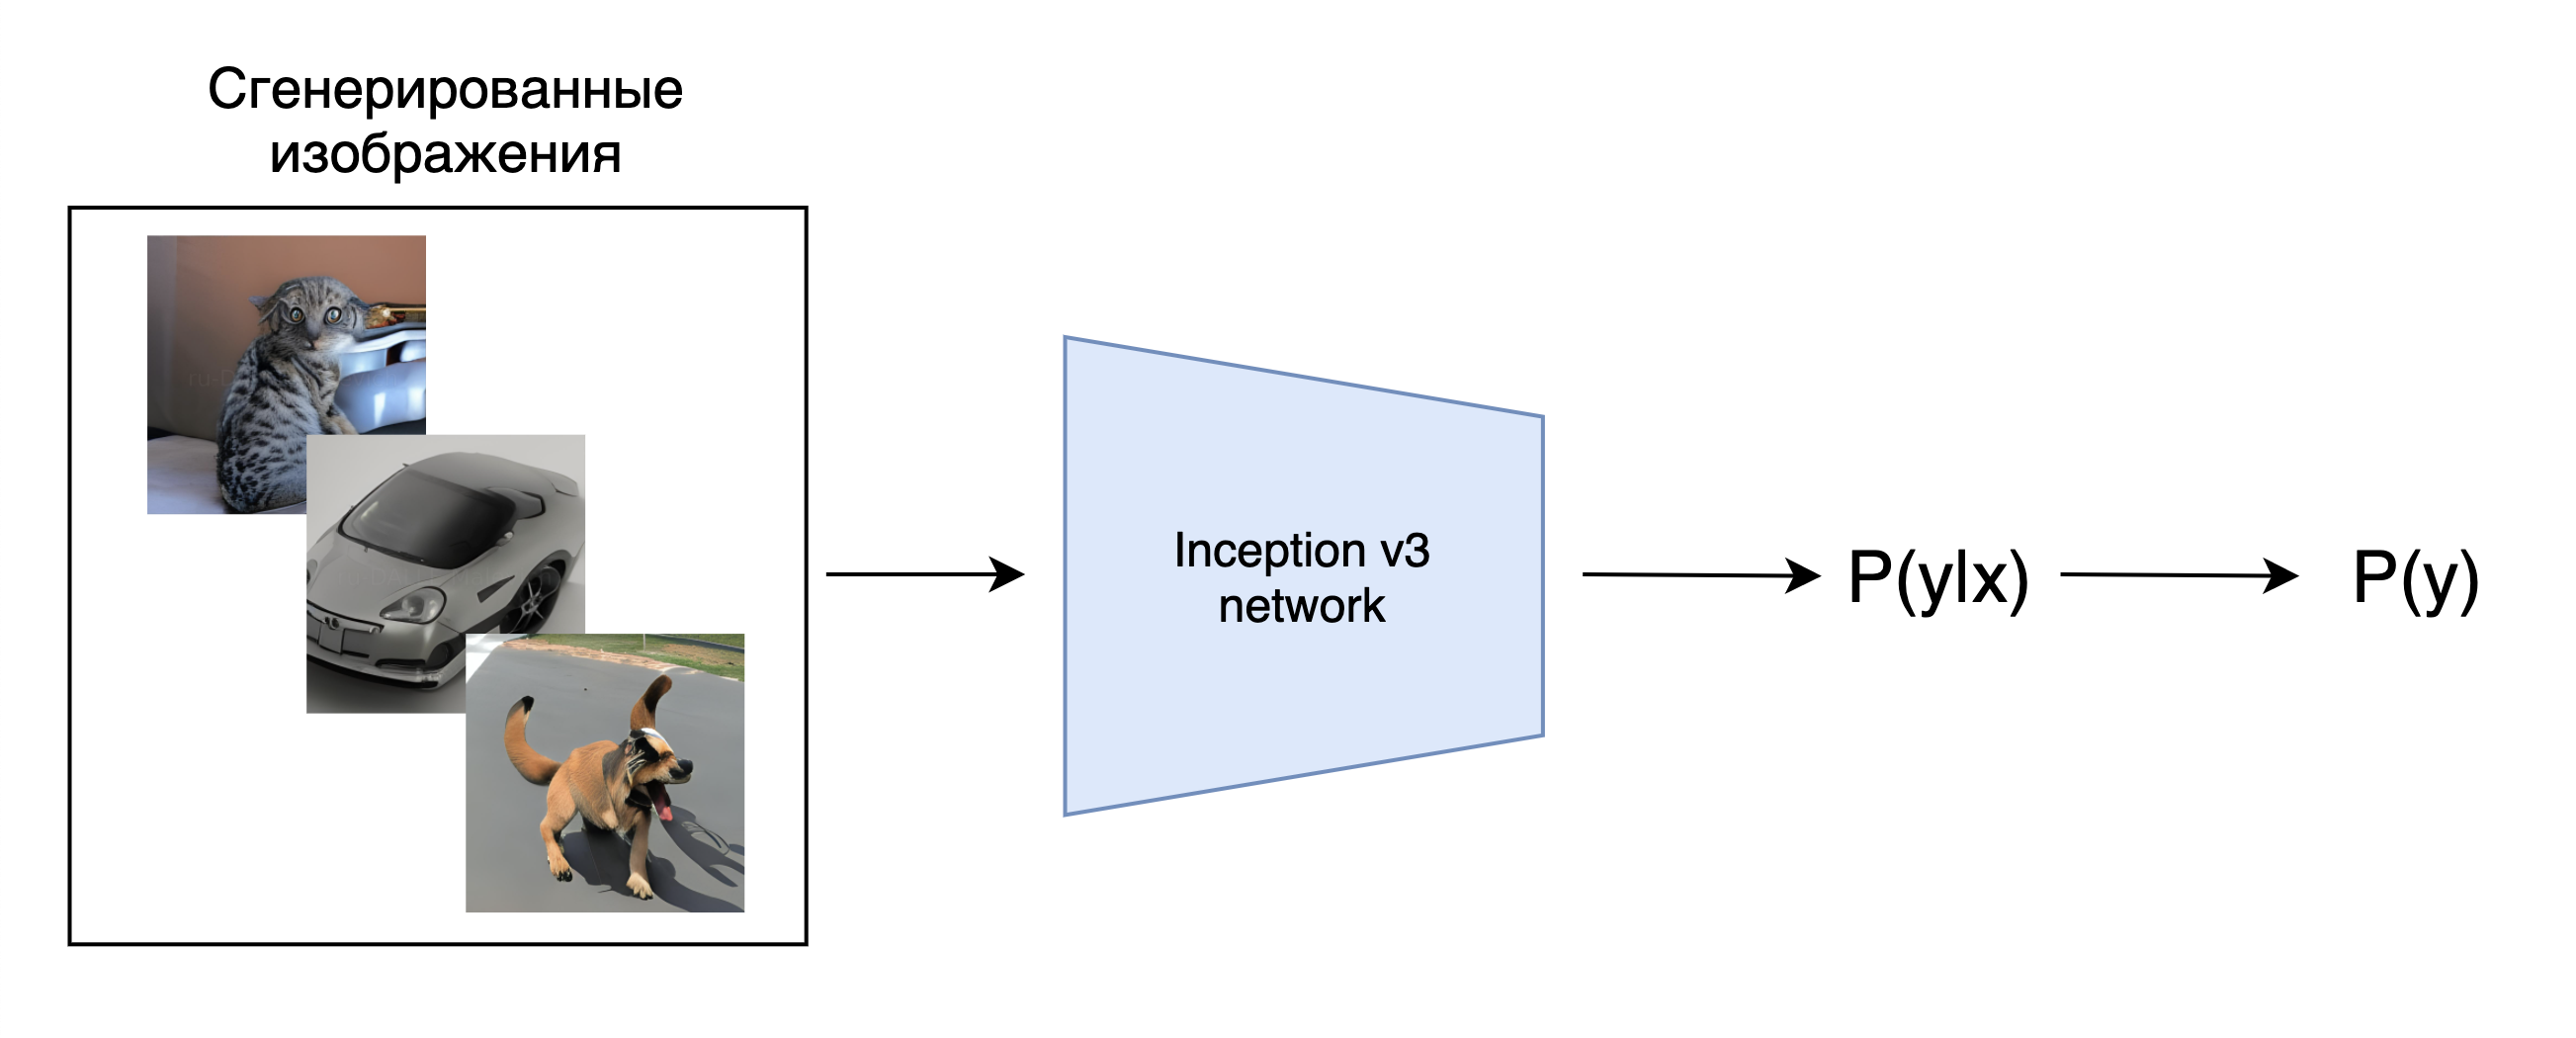

Для оценки метрики, называемой Inception score (IS), применяется классификатор Inception model, обученный на датасете ImageNet.

С помощью классификации сгенерированных изображений данной внешней моделью получается условное распределение лейблов от картинок $p(y|\mathbf{x})$. Сгенерированные картинки, похожие на что-то реальное из классов, которые есть в ImageNet, должны иметь распределение $p(y|x)$ с низкой энтропией:

\begin{equation}
    H(x) = - \sum_{i=1}^{n} p_i \log p_i
\end{equation}

То есть модель должна быть уверена, что на картинке изображена, например, собака.

Однако также сгенерированные изображения должны быть разнообразны, то есть наша модель генерации должна генерировать и кошек, и собак, и машины, а не только один какой-то понравившийся ей класс. Поэтому энтропия маргинализованного по пространству картинок распределения должна быть высокой.

\begin{equation}
    p(y) = \int_X p(y|x) dx
\end{equation}

Комбинируя эти два требования, получается метрика, которая меряет расстояние между двумя распределениями. Чем это расстояние больше, тем лучше. Метрика IS дается выражением:

\begin{equation}
    IS = exp \left( \mathbb{E}_{x \sim p_g} D_{KL}(p(y|x) \parallel p(y)) \right)
\end{equation}

где $D_{KL}$ - KL-дивергенция. $p_g$ - распределение сгенерированных изображений.

FID

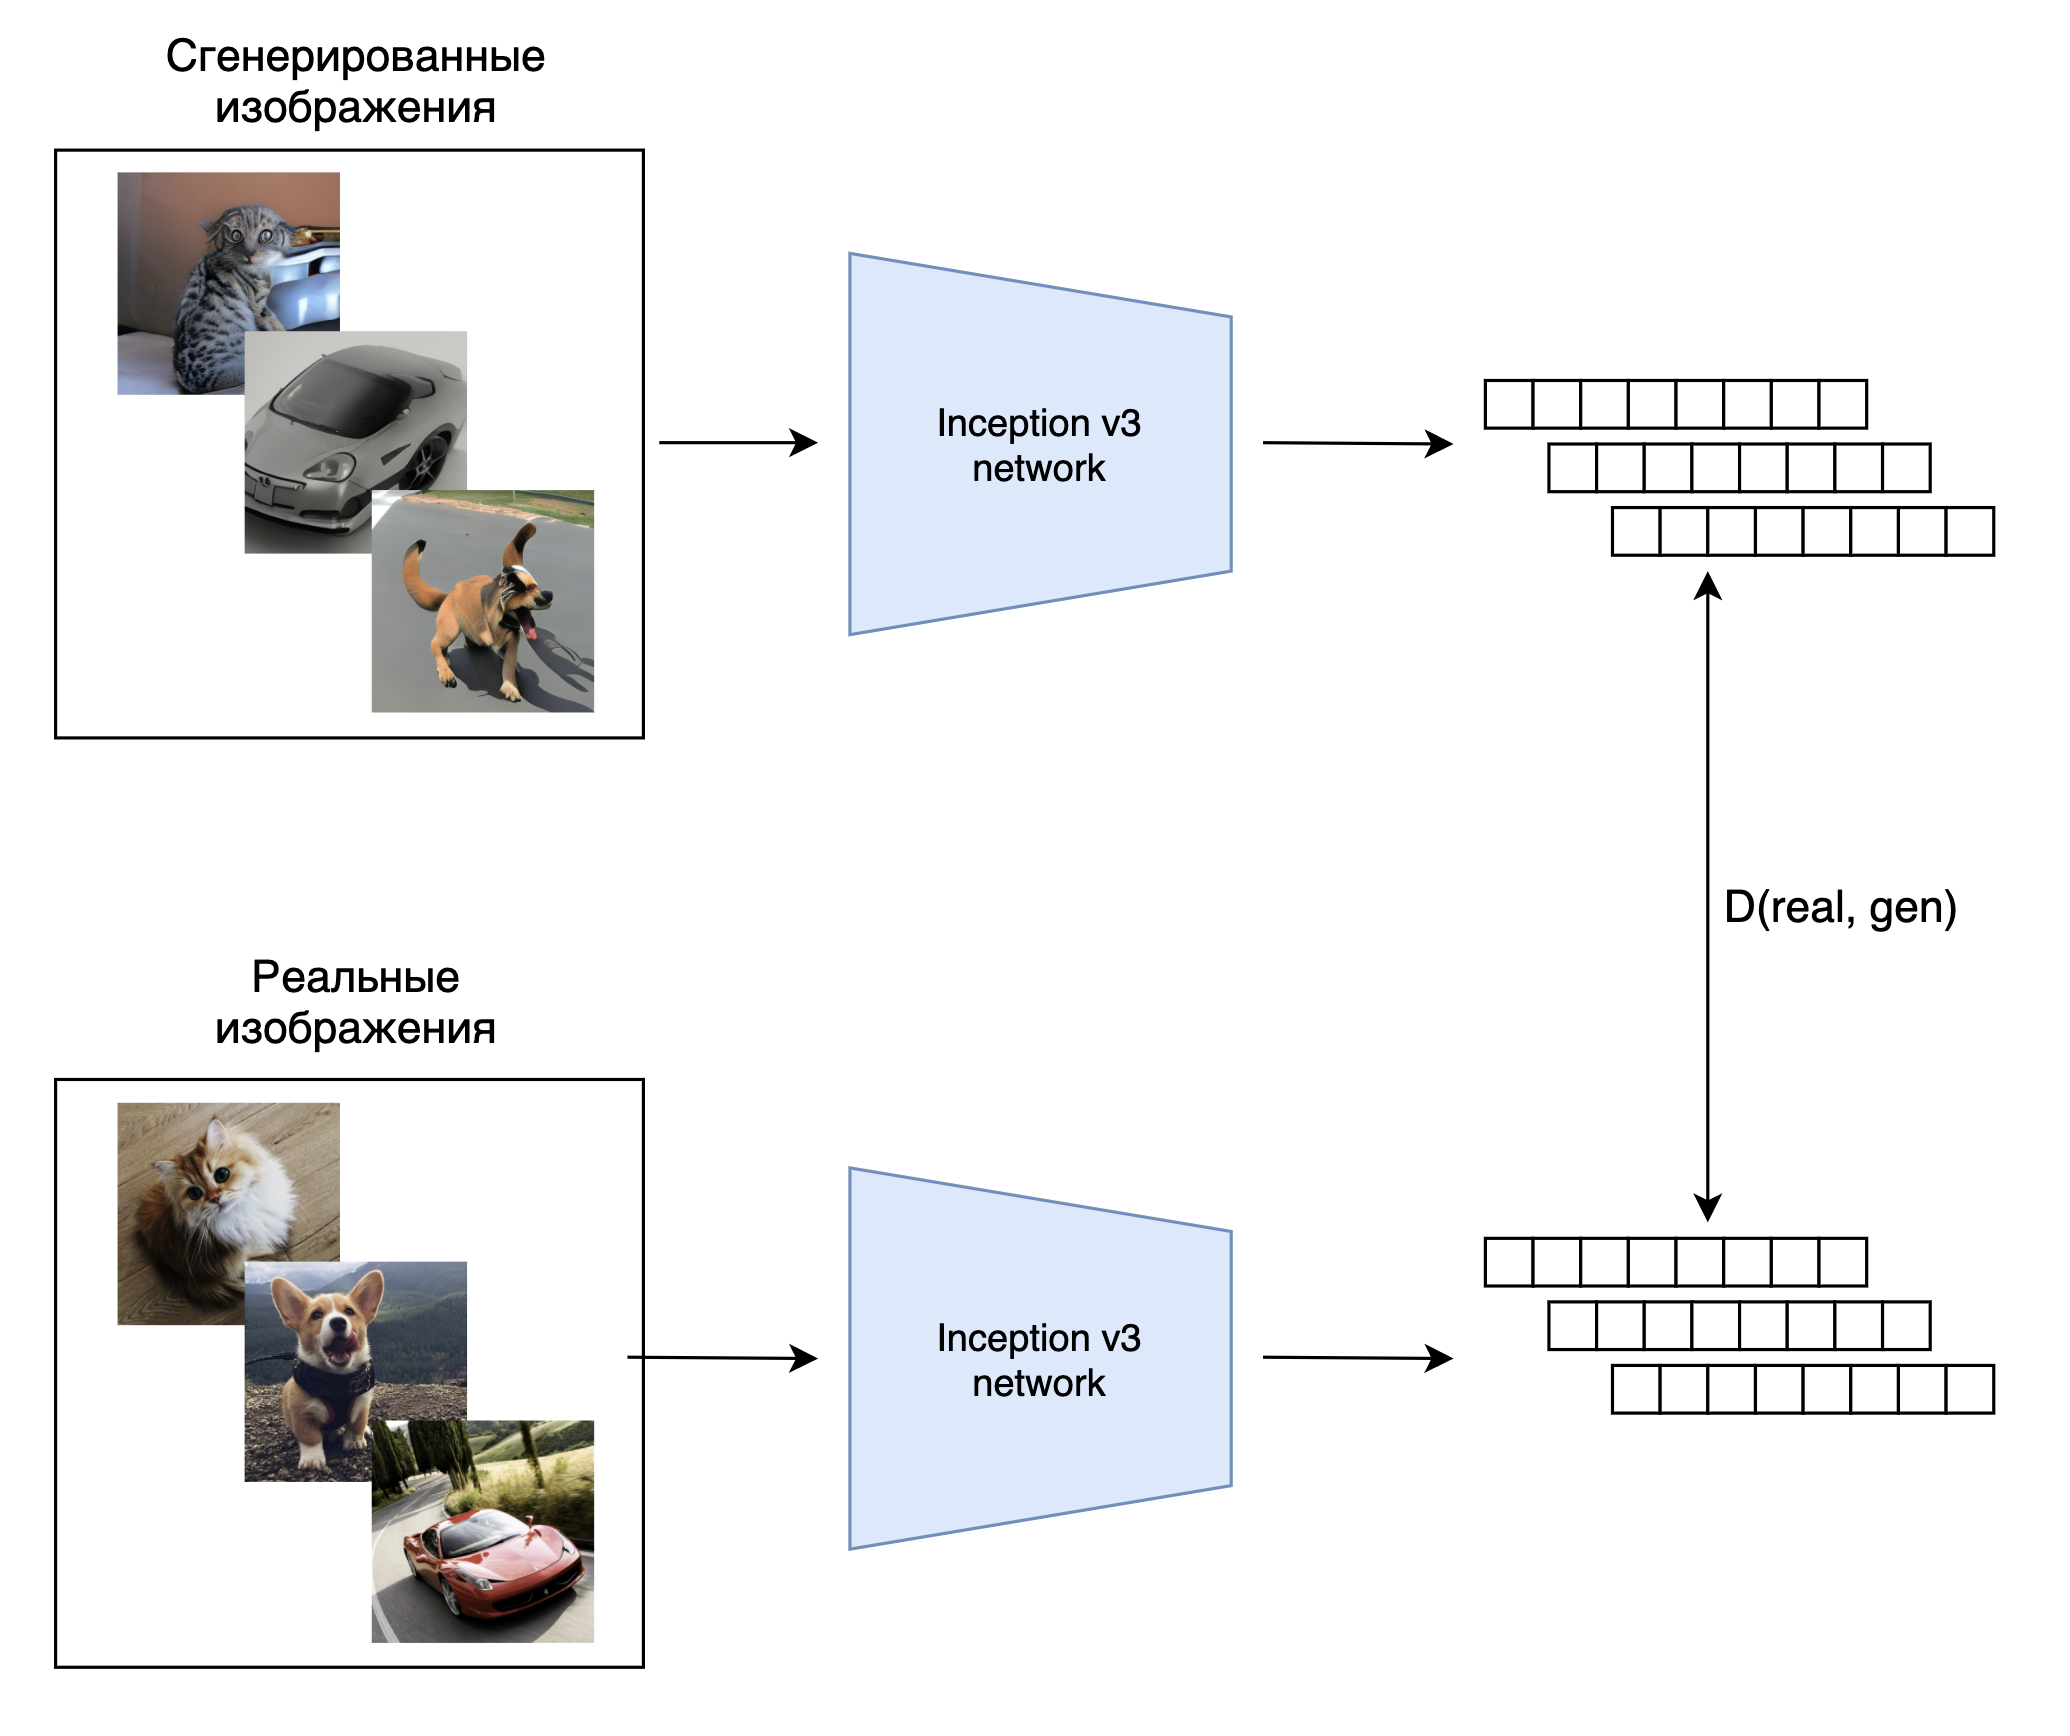

Минусом метрики IS является то, что она никак не учитывает распределение реальных данных для оценки качества сгенерированных изображений. Поэтому была предложена другая метрика Fréchet inception distance (FID).

Мотивация этой метрики состоит в том, чтобы сравнить распределения реальных и сгенерированных данных, или, другими словами, померить расстояние между двумя распределениями. Но измерения производятся не на самом распределении данных, а на некотором извлеченном из картинок представлении. Для этого каждое из сгенерированных изображений подается в модель Inception model (аналогично Inception Score), последний слой пуллинга (последний слой перед линейным преобразованием в логиты классификатора) которой выступает в качестве представления изображений. Inception v3 network, используемая для расчета обоих метрик, - это конкретная модель, поэтому можно сказать, что представление изображений в ней - это вектор длиной 2048. Представление получается также и для изображений исходного датасета.


Распределения двух полученных представлений упрощенно рассматриваются как многомерные Гауссианы, расстояние между которыми можно померить с помощью Fréchet distance.

Для одномерного нормального распределения расстояние будет выглядеть следующим образом:

\begin{equation}
    d(X, Y) = (\mu_X - \mu_Y)^2 + (\sigma_X - \sigma_Y)^2 = (\mu_X - \mu_Y)^2 + (\sigma^2_X + \sigma^2_Y - 2\sigma_X \sigma_Y)
\end{equation}

Для многомерного нормального распределения формула расстояния следующая:

\begin{equation}
    d(X, Y) = \| \mathbf{\mu}_X - \mathbf{\mu}_Y \|^2 + Tr(\mathbf{\Sigma}_X + \mathbf{\Sigma}_Y - 2\sqrt{\mathbf{\Sigma}_X \mathbf{\Sigma}_Y})
\end{equation}

Соответственно, FID показывает расстояние между сгенерированными изображениями и исходным реальным датасетом, поэтому, чем меньше расстояние, тем сгенерированные изображения лучше.

### Задание:

В данном задании нужно будет

* Обучить GAN и диффузию (DDPM) на датасете CIFAR10. Для GAN вы можете использовать методы регуляризации, чтобы улучшить его качество, например label smoothing, spectral normalization, подача шума на дискриминатор поверх сгенерированных и реальных данных (вспомогательный код для трюков в ганах приведен в ноутбуке). Переиспользуйте код из 1 и 2 домашней работы.

* Замерить качество генерации изображений с помощью метрик IS и FID. Привести примеры генерации и таблицу с результатами обучения моделей. Сравните метрики сгенерированных изображений с метриками исходного датасета.

Пример таблицы:



Model | IS $⇑$ | FID $⇓$ |
---------|------|-----------|
GAN | |
Diffusion | |
CIFAR10 | 10.98 ± 0.22 | 3.1508


### Define parameters & Load Dataset

In [1]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST, CIFAR10
from IPython.display import Image
from torchvision.utils import save_image
import os
%matplotlib inline
plt.style.use("ggplot")

class CFG:
    batch_size = 128
    num_epochs = 10
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = "data"
    nc = 3  ## number of chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images/"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

Label:  6


(array([ 140.,  578., 1378., 1406., 1163., 1691., 1246., 1402., 1351.,
         602.,  440.,  344.,  279.,  185.,   83.]),
 array([-0.99215686, -0.86091506, -0.72967321, -0.59843135, -0.46718955,
        -0.33594775, -0.20470589, -0.07346404,  0.05777776,  0.18901956,
         0.32026136,  0.45150328,  0.58274508,  0.71398687,  0.84522879,
         0.97647059]),
 <BarContainer object of 15 artists>)

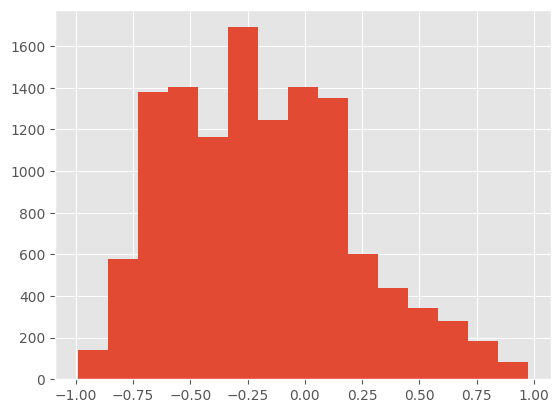

In [2]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, :, :].flatten(), bins=15)

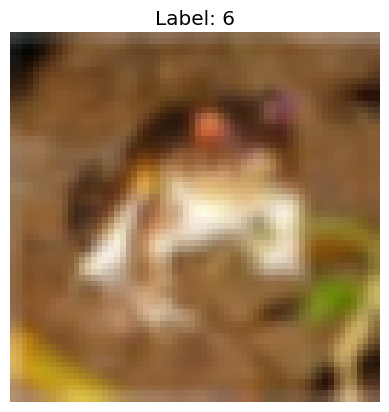

In [3]:


# unnormalization image from range (-1)-1 to range 0-1 to display it
def denorm(img):
    # write your code
    return (img + 1) / 2  # Преобразуем из [-1, 1] в [0, 1]

# show image sample with matplotlib
def show_image(img, label):
    img = denorm(img)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

show_image(img, label)

In [4]:
# define the dataloader
data_loader = torch.utils.data.DataLoader(
    cifar_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.workers
)

# Спектральная нормализация

In [5]:
import torch
from torch.optim.optimizer import Optimizer, required

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

## Tricks
- use deeper CNN
- use LeakyRELU instead of ReLU
- use BatchNorm, Dropout
- SpectralNorm

In [6]:
import torch.nn as nn
# Generator
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        super(Generator, self).__init__()
        # ConvTranspose2d nz ngf * 8
        # BatchNorm2d
        # ReLU
        # ConvTranspose2d ngf * 8 ngf * 4
        # BatchNorm2d
        # ReLU
        # ConvTranspose2d ngf * 4 ngf * 2
        # BatchNorm2d
        # ReLU
        # ConvTranspose2d ngf * 2 ngf
        # BatchNorm2d
        # ReLU
        # ConvTranspose2d ngf  nc
        # Sigmoid
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()  # Используем Tanh для выхода в диапазоне [-1, 1]
        )

    def forward(self, input):
        return self.main(input.unsqueeze(2).unsqueeze(3))

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        # SpectralNorm Conv2d
        # LeakyReLU
        # SpectralNorm Conv2d
        # BatchNorm2d
        # LeakyReLU
        # SpectralNorm Conv2d
        # BatchNorm2d
        # LeakyReLU
        # SpectralNorm Conv2d
        # BatchNorm2d
        # LeakyReLU
        # SpectralNorm Conv2d
        # Sigmoid
        self.main = nn.Sequential(
            SpectralNorm(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1)

In [7]:
# create new Generator model
G = Generator(CFG.nc, CFG.nz, CFG.ngf).to(CFG.device)

# create new Discriminator model
D = Discriminator(CFG.nc, CFG.ndf).to(CFG.device)

In [8]:
# show the output of model
y = G(torch.randn(2, CFG.nz).to(CFG.device))
print("Generator output shape:", y.shape)

Generator output shape: torch.Size([2, 3, 64, 64])


In [9]:
# feel free to reuse your training functions
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=CFG.lr, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=CFG.lr, betas=(0.5, 0.999))

batch_size = CFG.batch_size
latent_size = CFG.nz
device = CFG.device
sample_dir = CFG.sample_dir

Discriminator Training

In [10]:
# Label Smoothing, i.e. if you have two target labels: Real=1 and Fake=0, then for each incoming sample,
#  if it is real, then replace the label with a random number between 0.7 and 1.2, and
#  if it is a fake sample, replace it with 0.0 and 0.3 (for example).
#make the labels the noisy for the discriminator: occasionally flip the labels when training the discriminator

In [11]:
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()


LABEL_SMOOTH = 0.95
def train_discriminator(images):
    batch_size = images.size(0)
    device = images.device

    # Add small noise to real images to prevent overfitting
    noise_factor = 0.05 * np.random.uniform()
    noisy_images = images + noise_factor * torch.randn_like(images)

    # Create noisy labels
    real_labels = (torch.rand(batch_size, 1).to(device) * 0.5 + 0.7)
    fake_labels = (torch.rand(batch_size, 1).to(device) * 0.3)

    # Occasionally flip labels
    flip_prob = 0.05
    flip_mask_real = (torch.rand(batch_size, 1).to(device) < flip_prob).float()
    flip_mask_fake = (torch.rand(batch_size, 1).to(device) < flip_prob).float()

    final_real_labels = real_labels * (1 - flip_mask_real) + fake_labels * flip_mask_real
    final_fake_labels = fake_labels * (1 - flip_mask_fake) + real_labels * flip_mask_fake

    final_real_labels = torch.clamp(final_real_labels, 0.0, 1.0)
    final_fake_labels = torch.clamp(final_fake_labels, 0.0, 1.0)

    # Loss for real images
    outputs = D(noisy_images)
    d_loss_real = criterion(outputs, final_real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, CFG.nz).to(device)
    fake_images = G(z)

    # Add similar noise to fake images
    noisy_fake_images = fake_images + noise_factor * torch.randn_like(fake_images)
    outputs = D(noisy_fake_images.detach())
    d_loss_fake = criterion(outputs, final_fake_labels)
    fake_score = outputs

    # Sum losses
    d_loss = d_loss_real + d_loss_fake

    # Reset gradients
    reset_grad()

    # Compute gradients
    d_loss.backward()

    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

Generator Training

In [12]:
#Add gauss noise
#noise = 0.005*np.random.uniform()*np.amax(sound)

In [13]:
def train_generator():
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    z = np.random.normal(0, 1, (batch_size, latent_size))
    noise = 0.005*np.random.uniform()*np.amax(z)
    z = z.astype('float64') + noise*np.random.normal(size=z.shape)
    z = torch.Tensor(z).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)

    # calculate the generator loss
    outputs = D(fake_images)
    g_loss = criterion(outputs, labels)

    # Reset gradients
    reset_grad()

    # Backprop and optimize
    g_loss.backward()
    g_optimizer.step()

    return g_loss, fake_images

## Start the training process

In [14]:
def save_fake_images(index):
    # sample_vectors = torch.randn(batch_size, latent_size).to(device)
    z = np.random.normal(0, 1, (batch_size, latent_size))
    noise = 0.005*np.random.uniform()*np.amax(z)
    z = z.astype('float64') + noise*np.random.normal(size=z.shape)
    z = torch.Tensor(z).to(device)
    fake_images = G(z)
    # fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [15]:
%%time
device = CFG.device
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size

total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(images)

        # Train the generator
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/10], Step [200/391], d_loss: 1.0324, g_loss: 2.1391, D(x): 0.79, D(G(z)): 0.39
Saving fake_images-0001.png
Epoch [1/10], Step [200/391], d_loss: 1.1504, g_loss: 1.1948, D(x): 0.58, D(G(z)): 0.19
Saving fake_images-0002.png
Epoch [2/10], Step [200/391], d_loss: 1.0636, g_loss: 1.3515, D(x): 0.69, D(G(z)): 0.38
Saving fake_images-0003.png
Epoch [3/10], Step [200/391], d_loss: 1.1879, g_loss: 1.4455, D(x): 0.72, D(G(z)): 0.51
Saving fake_images-0004.png
Epoch [4/10], Step [200/391], d_loss: 1.2747, g_loss: 0.5315, D(x): 0.77, D(G(z)): 0.60
Saving fake_images-0005.png
Epoch [5/10], Step [200/391], d_loss: 1.0703, g_loss: 1.3909, D(x): 0.69, D(G(z)): 0.33
Saving fake_images-0006.png
Epoch [6/10], Step [200/391], d_loss: 0.9884, g_loss: 1.6125, D(x): 0.73, D(G(z)): 0.27
Saving fake_images-0007.png
Epoch [7/10], Step [200/391], d_loss: 1.5432, g_loss: 1.2455, D(x): 0.90, D(G(z)): 0.73
Saving fake_images-0008.png
Epoch [8/10], Step [200/391], d_loss: 1.1317, g_loss: 0.6838, D(x): 0.59

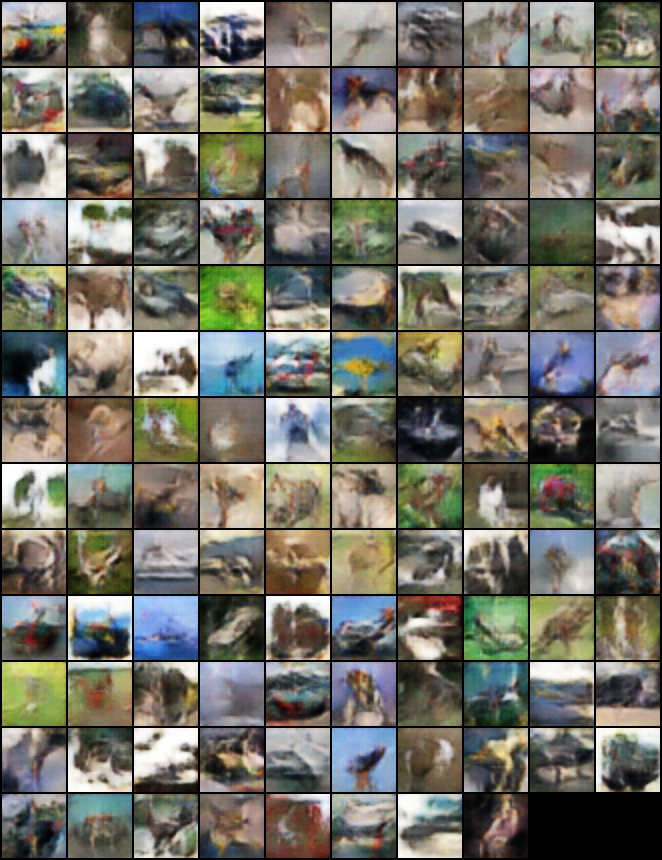

In [28]:
Image(os.path.join(sample_dir, 'fake_images-0009.png'))

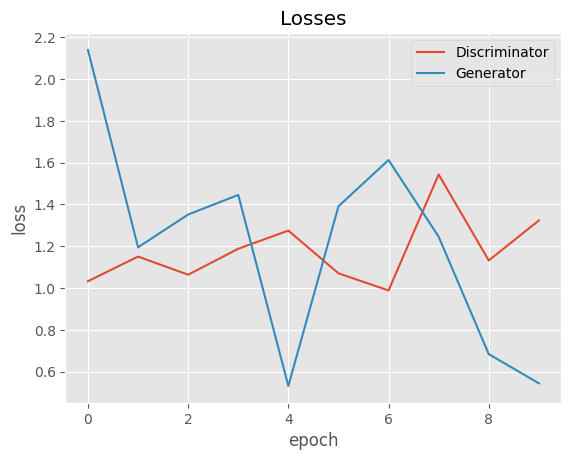

In [29]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

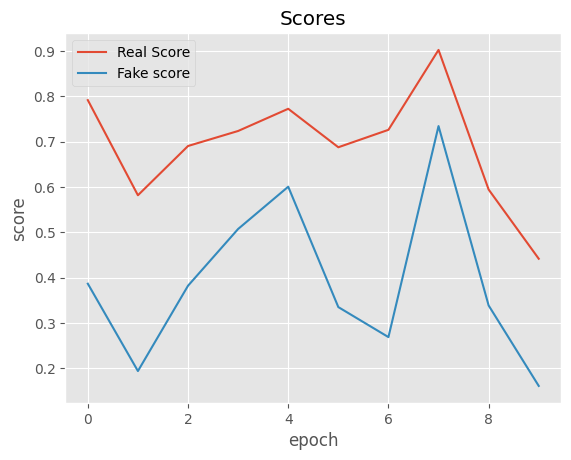

In [30]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

### install library from https://github.com/w86763777/pytorch-gan-metrics.git
Currently, this package supports following metrics:
- Inception Score (IS)
- Fréchet Inception Distance (FID)

In [46]:
# clone is repo: https://github.com/w86763777/pytorch-gan-metrics.git and install pytorch_gan_metrics
!git clone https://github.com/w86763777/pytorch_gan_metrics.git
# !pip install pytorch_image_generation_metrics

Cloning into 'pytorch_gan_metrics'...
remote: Repository not found.
fatal: repository 'https://github.com/w86763777/pytorch_gan_metrics.git/' not found


In [47]:
%cd pytorch-gan-metrics
#### Prepare Statistics for FID
!pip install -e .

[WinError 2] Не удается найти указанный файл: 'pytorch-gan-metrics'
c:\Users\Денис\Generative-Models-2025\Assignment 3\pytorch-gan-metrics


Obtaining file:///C:/Users/%D0%94%D0%B5%D0%BD%D0%B8%D1%81/Generative-Models-2025/Assignment%203/pytorch-gan-metrics
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for pytorch_image_generation_metrics (pyproject.toml): started
  Building editable for pytorch_image_generation_metrics (pyproject.toml): finished with status 'done'
  Created wheel for pytorch_image_generation_metrics: filename=pytorch_image_generation_metrics-0.6.1-0.editable-py3-none-any.whl size=9933 sha256=21823143209e5cd2e57d35db3ad967fbe1759a5917c4211326bfc0f


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\Users\Денис\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


In [52]:
!pip uninstall torch torchvision torchaudio -y
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Found existing installation: torch 2.8.0
Uninstalling torch-2.8.0:
  Successfully uninstalled torch-2.8.0


Looking in indexes: https://download.pytorch.org/whl/cpu
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
    --------------------------------------- 2.1/110.9 MB 11.9 MB/s eta 0:00:10
   - -------------------------------------- 4.7/110.9 MB 11.6 MB/s eta 0:00:10
   -- ------------------------------------- 7.1/110.9 MB 11.4 MB/s eta 0:00:10
   --- ------------------------------------ 9.7/110.9 MB 11.6 MB/s eta 0:00:09
   ---- ----------------------------------- 12.3/110.9 MB 11.7 MB/s eta 0:00:09
   ----- ---------------------------------- 14.7/110.9 MB 11.9 MB/s eta 0:00:09
   ------ --------------------------------- 17.3/110.9 MB 11.8 MB/s eta 0:00:08
   ------- -------------------------------- 19.9/110.9 MB 11.9 MB/s eta 0:00:08
   -------- ------------------------------- 22.3/110.9 MB 11.8 MB/s eta 0:00:08
   -------- ------------------------------- 24.9/110.9 MB 11.9 MB/s eta 0:00:08
   --------- ------------------------------ 27.3/110.9 MB 11.9 MB/s eta 0:00


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\Users\Денис\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


In [ ]:
# First, let's ensure we're using CPU
import torch
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
device = torch.device('cpu')

print(f"Using device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Import necessary modules
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
import numpy as np

# create the Generator Dataset
class GeneratorDataset(Dataset):
    def __init__(self, G, z_dim):
        self.G = G
        self.z_dim = z_dim
        self.G.eval()
        self.G.to(device)

    def __len__(self):
        return 500

    def __getitem__(self, index):
        with torch.no_grad():
            z = torch.randn(1, self.z_dim, device=device)
            img = self.G(z)[0]
        return img

# define dataset
generator_dataset = GeneratorDataset(G, CFG.nz)

# create dataloader
generator_loader = DataLoader(generator_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=0)

# Collect generated images
print("Collecting generated images...")
generated_images = []
for batch in generator_loader:
    batch = batch.to(device)
    img = (batch + 1) / 2  # From [-1, 1] to [0, 1]
    img = torch.clamp(img, 0, 1)
    generated_images.append(img.cpu())
generated_images = torch.cat(generated_images, dim=0)

# Collect real images from CIFAR10 for FID
print("\nCollecting real images for comparison...")
os.makedirs(CFG.dataroot, exist_ok=True)
real_dataset = CIFAR10(
    root=CFG.dataroot,
    download=True,
    transform=transforms.Compose([
        transforms.Resize([CFG.image_size, CFG.image_size]),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
)

real_loader = DataLoader(real_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=0)
real_images = []
for images, _ in real_loader:
    images = images.to(device)
    img = (images + 1) / 2  # From [-1, 1] to [0, 1]
    img = torch.clamp(img, 0, 1)
    real_images.append(img.cpu())
real_images = torch.cat(real_images, dim=0)

# Ensure equal number of images for fair comparison
num_images = min(len(generated_images), len(real_images))
generated_images = generated_images[:num_images]
real_images = real_images[:num_images]

print(f"\nUsing {num_images} images for IS and FID calculation.")

# ============================================================
# SIMPLE MANUAL METRICS CALCULATION
# ============================================================

print("\n" + "="*60)
print("Step 1: Computing Inception Score...")
print("="*60)

# Simple manual Inception Score calculation
def manual_inception_score(images, splits=10, batch_size=32):
    from torchvision.models import inception_v3
    import torch.nn as nn
    import torch.nn.functional as F
    
    # Load model
    model = inception_v3(pretrained=True, transform_input=False)
    model.eval()
    model.fc = nn.Identity()  # Remove final layer for features
    model.to(device)
    
    for param in model.parameters():
        param.requires_grad = False
    
    # Get features
    features = []
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size].to(device)
            if batch.shape[2] != 299:
                batch = F.interpolate(batch, size=(299, 299), mode='bilinear')
            feat = model(batch)
            features.append(feat.cpu().numpy())
    
    features = np.concatenate(features, axis=0)
    
    # Apply softmax to get probabilities
    probs = np.exp(features) / np.sum(np.exp(features), axis=1, keepdims=True)
    
    # Calculate IS
    scores = []
    for i in range(splits):
        part = probs[(i * probs.shape[0] // splits):((i + 1) * probs.shape[0] // splits), :]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
        kl = np.mean(np.sum(kl, 1))
        scores.append(np.exp(kl))
    
    return np.mean(scores), np.std(scores)

is_mean, is_std = manual_inception_score(generated_images, batch_size=CFG.batch_size)
print(f"\n Inception Score (IS): {is_mean:.4f} ± {is_std:.4f}")

print("\n" + "="*60)
print("Step 2: Computing Fréchet Inception Distance...")
print("="*60)

def manual_fid(real_images, fake_images, batch_size=32):
    from torchvision.models import inception_v3
    import torch.nn as nn
    import torch.nn.functional as F
    from scipy import linalg
    
    # Load model
    model = inception_v3(pretrained=True, transform_input=False)
    model.eval()
    model.fc = nn.Identity()  # Get 2048-dimensional features
    model.to(device)
    
    for param in model.parameters():
        param.requires_grad = False
    
    def get_features(imgs):
        features = []
        with torch.no_grad():
            for i in range(0, len(imgs), batch_size):
                batch = imgs[i:i+batch_size].to(device)
                if batch.shape[2] != 299:
                    batch = F.interpolate(batch, size=(299, 299), mode='bilinear')
                feat = model(batch)
                features.append(feat.cpu().numpy())
        return np.concatenate(features, axis=0)
    
    # Get features
    real_features = get_features(real_images)
    fake_features = get_features(fake_images)
    
    # Calculate statistics
    mu_real = np.mean(real_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)
    
    mu_fake = np.mean(fake_features, axis=0)
    sigma_fake = np.cov(fake_features, rowvar=False)
    
    # Calculate FID
    diff = mu_real - mu_fake
    covmean, _ = linalg.sqrtm(sigma_real.dot(sigma_fake), disp=False)
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid

fid_value = manual_fid(real_images, generated_images, batch_size=CFG.batch_size)
print(f"\n Fréchet Inception Distance (FID): {fid_value:.4f}")

# Final output
print("\n" + "="*60)
print("FINAL METRICS FOR GAN")
print("="*60)
print(f"Inception Score: {is_mean:.4f} ± {is_std:.4f}")
print(f"FID: {fid_value:.4f}")
print("="*60)

print("\nComparison table:")
print("-" * 45)
print("Model           | IS              | FID")
print("-" * 45)
print(f"GAN (Your Model) | {is_mean:.2f} ± {is_std:.2f} | {fid_value:.4f}")
print("-" * 45)

print("\n" + "="*60)
print("Saving FID statistics for future use...")
print("="*60)

# Save real image statistics for future use
stats_path = os.path.join(CFG.dataroot, 'cifar10_train_stats.npz')

# Get real features one more time for saving
from torchvision.models import inception_v3
import torch.nn as nn
import torch.nn.functional as F

model = inception_v3(pretrained=True, transform_input=False)
model.eval()
model.fc = nn.Identity()
model.to(device)

real_features = []
with torch.no_grad():
    for i in range(0, len(real_images), CFG.batch_size):
        batch = real_images[i:i+CFG.batch_size].to(device)
        if batch.shape[2] != 299:
            batch = F.interpolate(batch, size=(299, 299), mode='bilinear')
        feat = model(batch)
        real_features.append(feat.cpu().numpy())

real_features = np.concatenate(real_features, axis=0)
mu_real = np.mean(real_features, axis=0)
sigma_real = np.cov(real_features, rowvar=False)

np.savez(stats_path, mu=mu_real, sigma=sigma_real)
print(f" Real image statistics saved to: {stats_path}")
print(f"  To use in future calculations, load with: np.load('{stats_path}')")

Using device: cpu
CUDA available: False


Using 500 images for IS and FID calculation.

Step 1: Computing Inception Score...


C:\Users\Денис\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Денис\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\Денис/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth


100.0%



✅ Inception Score (IS): 1.0569 ± 0.0056

Step 2: Computing Fréchet Inception Distance...


C:\Users\Денис\AppData\Local\Temp\ipykernel_30800\589910074.py:172: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma_real.dot(sigma_fake), disp=False)



✅ Fréchet Inception Distance (FID): 163.4472

FINAL METRICS FOR GAN
Inception Score: 1.0569 ± 0.0056
FID: 163.4472

Comparison table:
---------------------------------------------
Model           | IS              | FID
---------------------------------------------
GAN (Your Model) | 1.06 ± 0.01 | 163.4472
---------------------------------------------

Saving FID statistics for future use...
✅ Real image statistics saved to: data\cifar10_train_stats.npz
   To use in future calculations, load with: np.load('data\cifar10_train_stats.npz')
